# Pre-processing & Training Data Development

## 1. Imports packages

In [17]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [18]:
sns.set()

## 2. Load Data

In [27]:
train = pd.read_csv("bank.csv")

In [115]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,cluster
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1.000,0.000,0.000,unknown,yes,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1.000,0.000,0.000,unknown,yes,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1.000,0.000,0.000,unknown,yes,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1.000,0.000,0.000,unknown,yes,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2.000,0.000,0.000,unknown,yes,1


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


## 3. Imput Outliers by Mean

In [112]:
# Calculate the mean of the values less than or equal to 34
pmean_value = train[train['previous'] > 34]['previous'].mean()

# Replace values greater than 34 with the calculated mean
train['previous'] = df['previous'].apply(lambda x: pmean_value if x > 34 else x)

# Calculate the mean of the values less than or equal to 34
cmean_value = train[train['campaign'] > 34]['campaign'].mean()

# Replace values greater than 34 with the calculated mean
train['campaign'] = df['campaign'].apply(lambda x: cmean_value if x > 34 else x)

# Calculate the mean of the values less than or equal to 400
pdmean_value = train[train['pdays'] > 400]['pdays'].mean()

# Replace values greater than 34 with the calculated mean
train['pdays'] = df['pdays'].apply(lambda x: pdmean_value if x > 400 else x)

#Replace pdays value:-1 to 0
train['pdays'] = train['pdays'].replace(-1, 0)

## 4. Create Customer Segmentation with K-Means

Customer Data:
- age: (numeric)
- job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-emplo yed','services','student','technician','unemployed','unknown')
- marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education: (categorical: primary, secondary, tertiary and unknown)
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
- balance: Balance of the individual.

In [57]:
df_cust = train[['age','job','education','marital']]

In [58]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   education  11162 non-null  object
 3   marital    11162 non-null  object
dtypes: int64(1), object(3)
memory usage: 348.9+ KB


In [59]:
cont_features = []
cat_features = []

for c in df_cust.columns:
    if df_cust[c].dtype == 'int64':
        cont_features += [c]
    else:
        cat_features += [c]

In [60]:
df_cust[cat_features].nunique()

job          12
education     4
marital       3
dtype: int64

In [61]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df_cust[cat_features]))
OH_cols.index = df.index

df_cont = df_cust.drop(cat_features, axis=1)

df_OH = pd.concat([df_cont, OH_cols], axis=1)

<AxesSubplot:xlabel='age', ylabel='Density'>

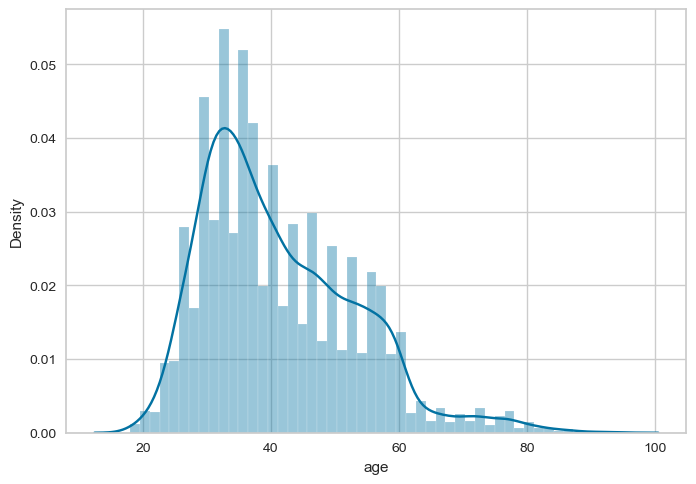

In [62]:
fig, ax = plt.subplots()
sns.distplot(df_OH['age'])

<AxesSubplot:xlabel='age', ylabel='Density'>

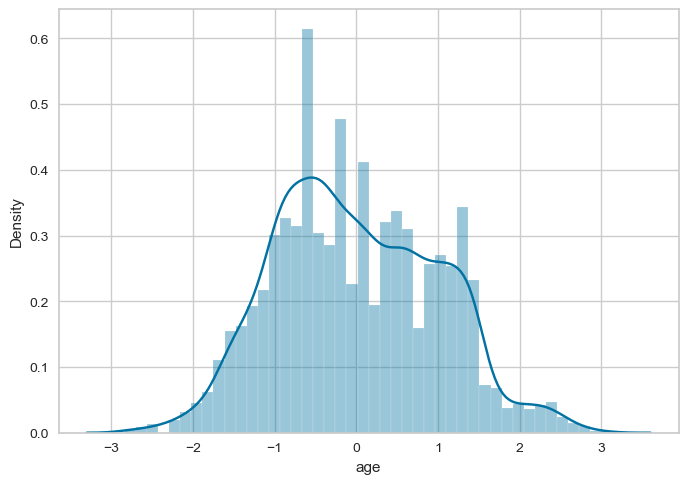

In [63]:
df_OH[cont_features] = np.log(df_OH[cont_features])
scaler = StandardScaler()
df_OH[cont_features] = scaler.fit_transform(df_OH[cont_features])
df[cont_features] = scaler.fit_transform(df[cont_features])

fig, ax = plt.subplots()
sns.distplot(df_OH['age'])

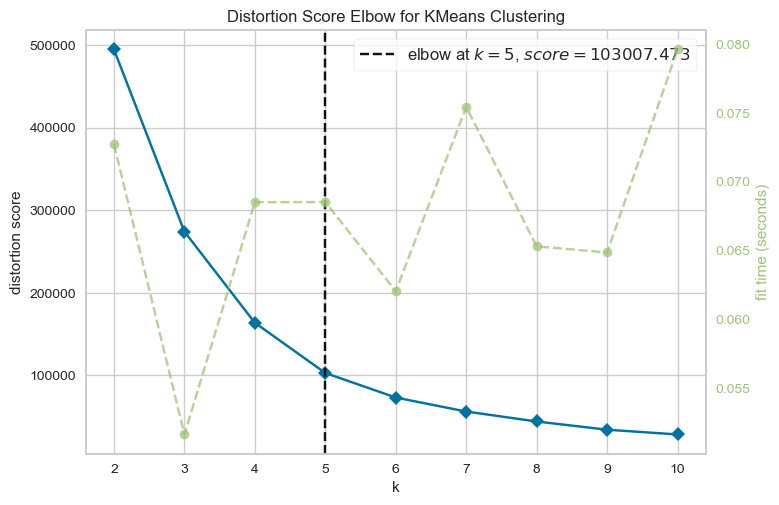

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [64]:
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_cust[cont_features])
Elbow_M.show()

In [73]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=30, max_iter=100)
clusters = kmeans.fit_predict(df_cust[cont_features])
df_cust['cluster'] = clusters

In [140]:
df_cust

,age,job,education,marital,cluster
0,59,admin.,secondary,married,1
1,56,admin.,secondary,married,1
2,41,technician,secondary,married,4
3,55,services,secondary,married,1
4,54,admin.,tertiary,married,1
...,...,...,...,...,...
11157,33,blue-collar,primary,single,0
11158,39,services,secondary,married,4
11159,32,technician,secondary,single,0
11160,43,technician,secondary,married,2


In [77]:
df_cust.groupby(['cluster']).agg(['min', 'median', 'mean', 'max', 'sum', 'count']).round()

age                                
        min median   mean max     sum count
cluster                                    
0        18 30.000 29.000  33  100593  3444
1        52 56.000 57.000  65  106356  1879
2        42 46.000 46.000  51  110482  2391
3        66 73.000 74.000  95   29489   398
4        34 37.000 37.000  41  113311  3050

In [141]:
train.shape

(11162, 18)

In [81]:
# join dataframes on common columns
joined_df = pd.merge(train, df_cust, on=['age', 'job', 'education', 'marital'], how='inner')

# add 'cluster' column from joined dataframe to dataset A
train['cluster'] = joined_df['cluster']

In [82]:
train.shape

(11162, 18)

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  float64
 13  pdays      11162 non-null  float64
 14  previous   11162 non-null  float64
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
 17  cluster    11162 non-null  int32  
dtypes: float64(3), int32(1), int64(4), object(10)
memory usage: 1.5+ MB


## 5.Differentiate numerical features (minus the target) and categorical features

In [219]:
categorical_features = train.select_dtypes(include = ["object"]).columns
categorical_features = categorical_features.drop("deposit")

numerical_features = train.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 8
Categorical features : 9


In [220]:
train_num

,age,balance,day,duration,campaign,pdays,previous,cluster
0,59,2343,5,1042,1.000,0.000,0.000,1
1,56,45,5,1467,1.000,0.000,0.000,1
2,41,1270,5,1389,1.000,0.000,0.000,1
3,55,2476,5,579,1.000,0.000,0.000,1
4,54,184,5,673,2.000,0.000,0.000,1
...,...,...,...,...,...,...,...,...
11157,33,1,20,257,1.000,0.000,0.000,0
11158,39,733,16,83,4.000,0.000,0.000,0
11159,32,29,19,156,2.000,0.000,0.000,0
11160,43,0,8,9,2.000,172.000,5.000,0


In [212]:
train_num.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.000,41.232,11.913,18.000,32.000,39.000,49.000,95.000
balance,11162.000,1528.539,3225.413,-6847.000,122.000,550.000,1708.000,81204.000
day,11162.000,15.658,8.421,1.000,8.000,15.000,22.000,31.000
duration,11162.000,371.994,347.128,2.000,138.000,255.000,496.000,3881.000
campaign,11162.000,2.508,2.717,1.000,1.000,2.000,3.000,47.500
pdays,11162.000,52.076,107.546,0.000,0.000,0.000,20.750,524.866
previous,11162.000,0.833,2.285,0.000,0.000,0.000,1.000,46.200
cluster,11162.000,1.298,1.704,0.000,0.000,0.000,4.000,4.000


In [221]:
# Removing balance < 0
train_num = train_num[train_num['balance']>0]

In [222]:
train_num.describe().T

,count,mean,std,min,25%,50%,75%,max
age,9700.000,41.255,12.130,18.000,32.000,39.000,49.000,95.000
balance,9700.000,1781.889,3386.007,1.000,258.000,730.000,2021.250,81204.000
day,9700.000,15.568,8.392,1.000,8.000,15.000,21.000,31.000
duration,9700.000,372.763,345.913,2.000,140.000,257.000,493.000,3881.000
campaign,9700.000,2.463,2.616,1.000,1.000,2.000,3.000,47.500
pdays,9700.000,54.184,108.773,0.000,0.000,0.000,83.000,524.866
previous,9700.000,0.873,2.350,0.000,0.000,0.000,1.000,46.200
cluster,9700.000,1.294,1.699,0.000,0.000,0.000,4.000,4.000


In [144]:
train_cat

,job,marital,education,default,housing,loan,contact,month,poutcome
0,admin.,married,secondary,no,yes,no,unknown,may,unknown
1,admin.,married,secondary,no,no,no,unknown,may,unknown
2,technician,married,secondary,no,yes,no,unknown,may,unknown
3,services,married,secondary,no,yes,no,unknown,may,unknown
4,admin.,married,tertiary,no,no,no,unknown,may,unknown
...,...,...,...,...,...,...,...,...,...
11157,blue-collar,single,primary,no,yes,no,cellular,apr,unknown
11158,services,married,secondary,no,no,no,unknown,jun,unknown
11159,technician,single,secondary,no,no,no,cellular,aug,unknown
11160,technician,married,secondary,no,no,yes,cellular,may,failure


## 6.Log transform of the skewed numerical features to lessen impact of outliers

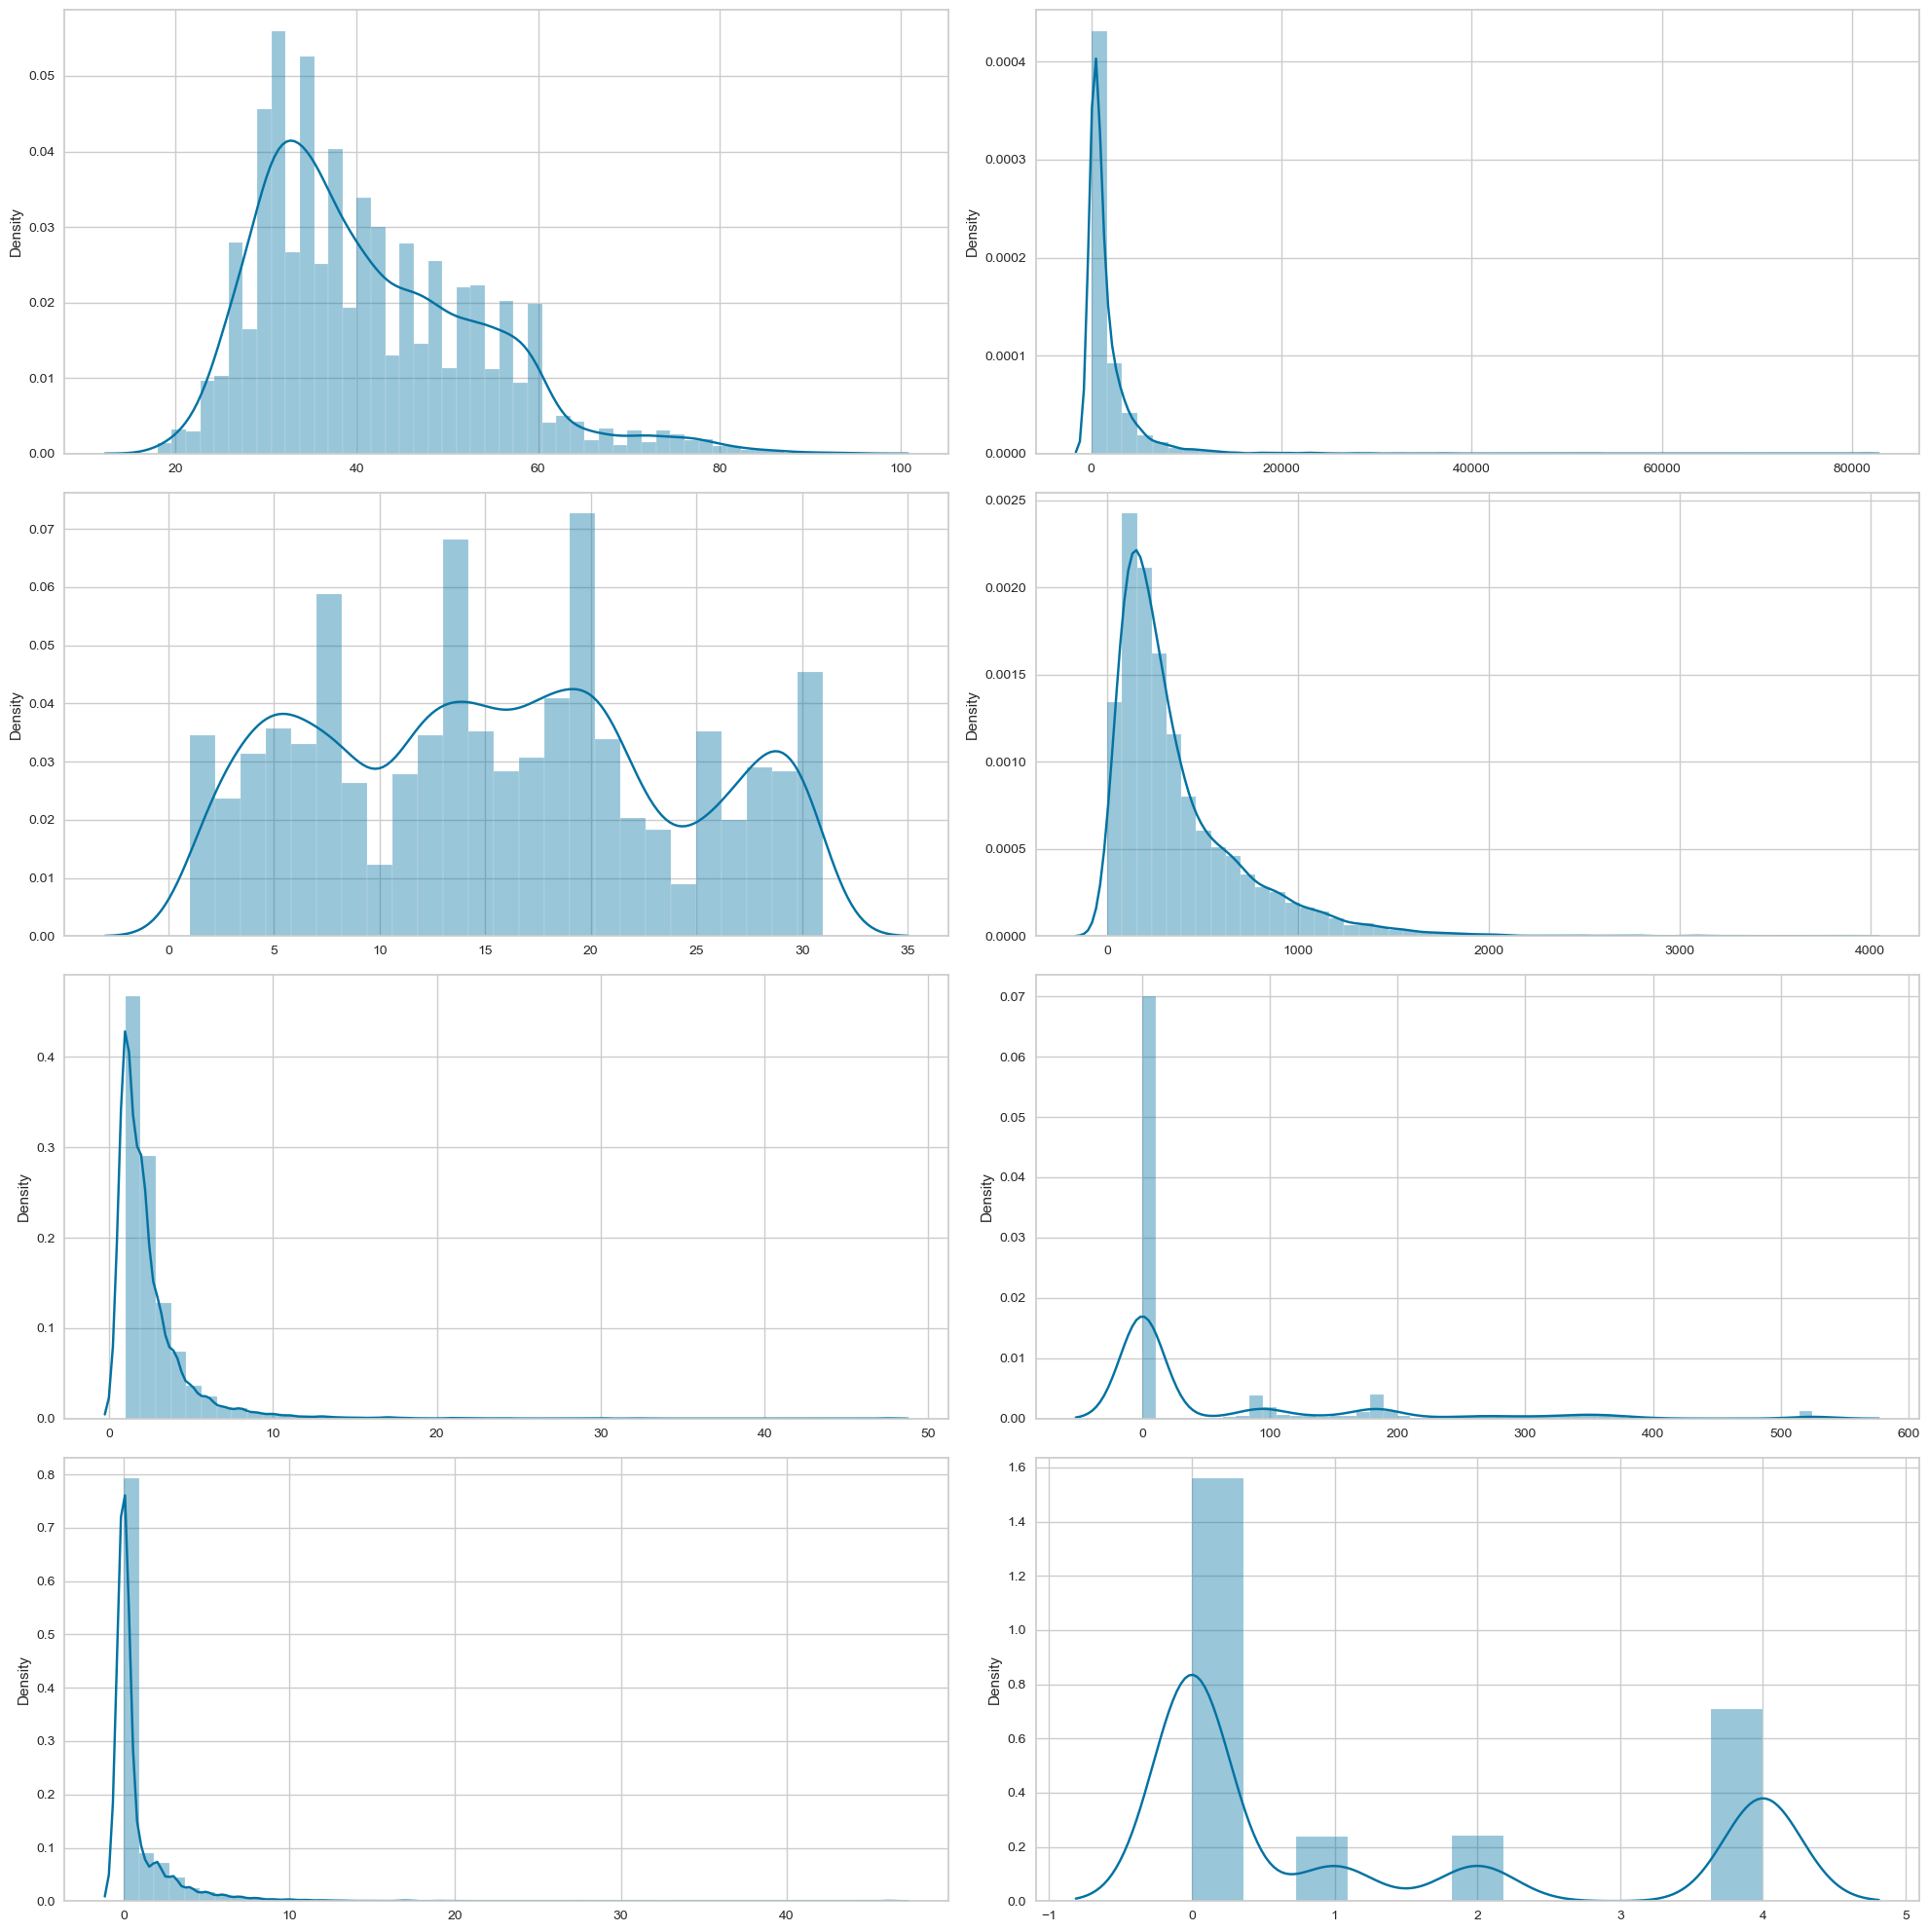

In [223]:
# List of columns to plot
columns_to_plot = train_num.columns.tolist()

# Define the number of rows and columns for the grid
n_rows = 4
n_cols = 2

# Create the subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

# Create a histogram plot with percentage labels for each column
for idx, column in enumerate(columns_to_plot):
    ax = axes[idx]
    sns.distplot(x=train_num[column], ax=ax)
    
# Remove unused subplots
for ax in axes[len(columns_to_plot):]:
    ax.axis('off')

# Adjust layout and show the grid of plots
plt.tight_layout()
plt.show()

In [225]:
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewness

print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

7 skewed numerical features to log transform


In [227]:
scaler = StandardScaler()
train_num[skewed_features] = scaler.fit_transform(train_num[skewed_features])

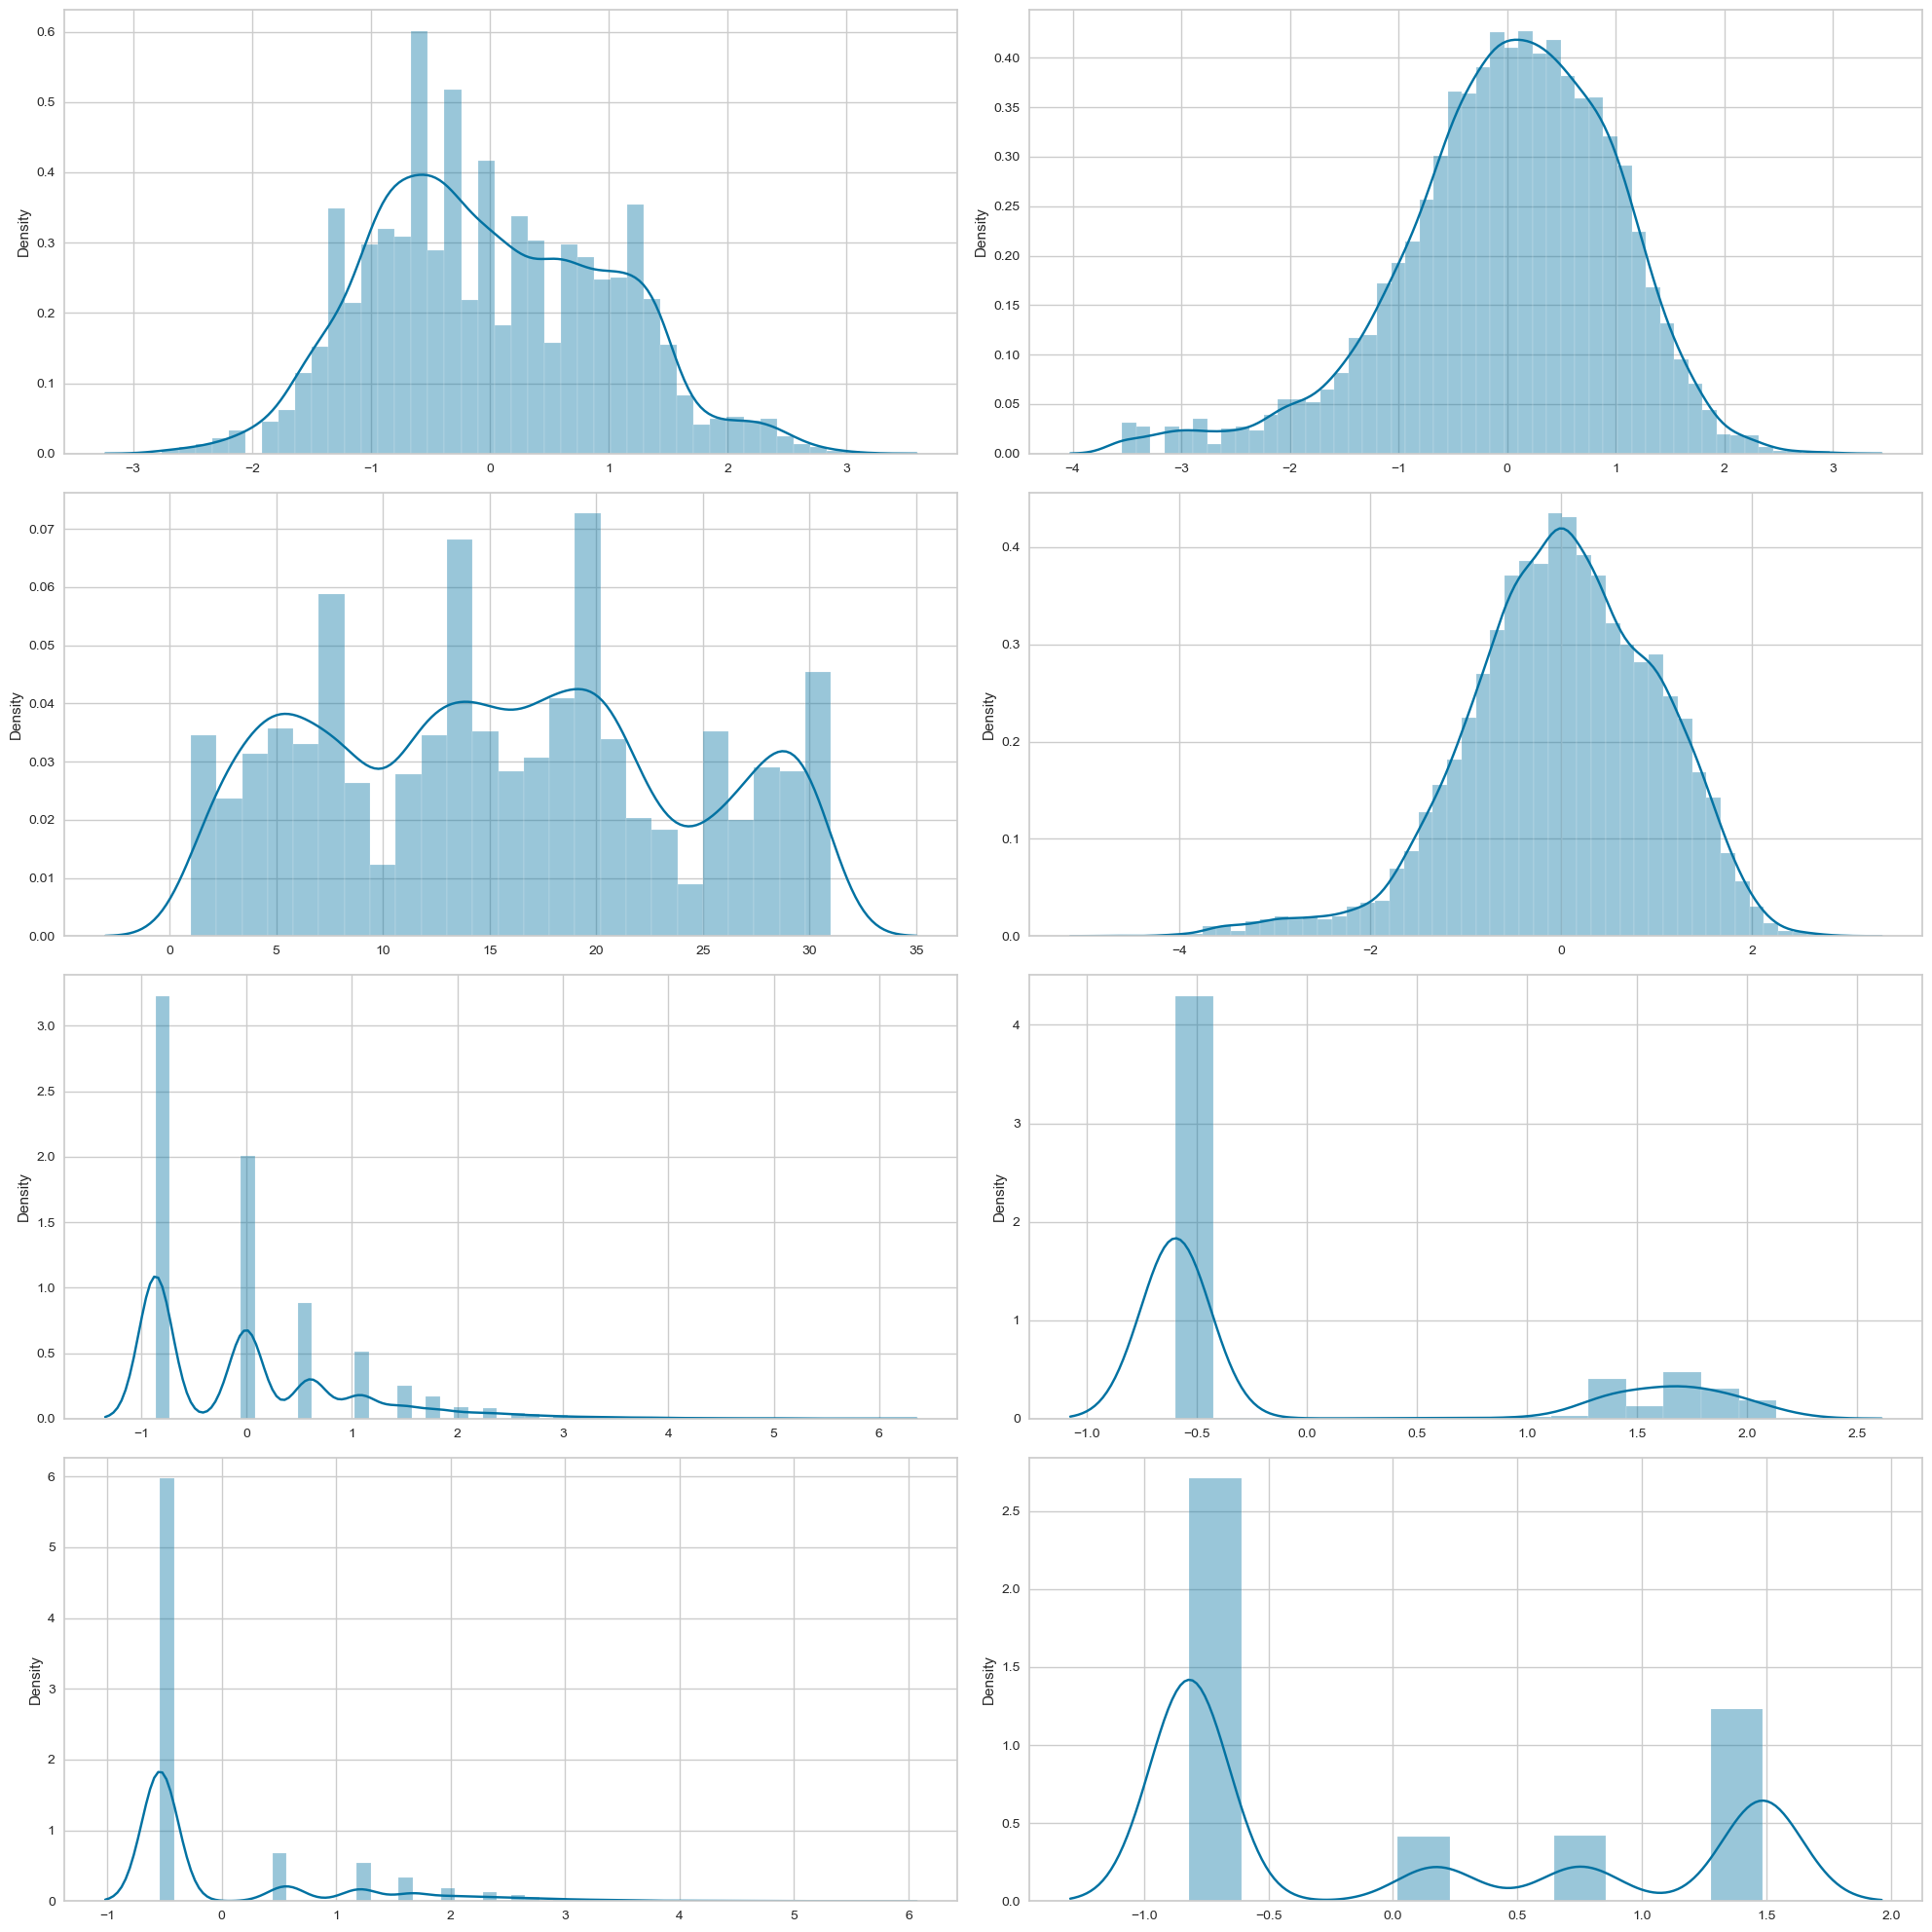

In [230]:
# List of columns to plot
columns_to_plot = train_num.columns.tolist()

# Define the number of rows and columns for the grid
n_rows = 4
n_cols = 2

# Create the subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

# Create a histogram plot with percentage labels for each column
for idx, column in enumerate(columns_to_plot):
    ax = axes[idx]
    sns.distplot(x=train_num[column], ax=ax)
    
# Remove unused subplots
for ax in axes[len(columns_to_plot):]:
    ax.axis('off')

# Adjust layout and show the grid of plots
plt.tight_layout()
plt.show()

## 6. Transformation of categorical features

In [231]:
# Create dummy features for categorical values via one-hot encoding
train_cat = pd.get_dummies(train_cat)
train_cat.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


## 7. Split into testing and training datasets

In [232]:
# Join categorical and numerical features
X = pd.concat([train_num, train_cat], axis = 1)
y= train.deposit
print("New number of features : " + str(df.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 17
X_train : (7813, 52)
X_test : (3349, 52)
y_train : (7813,)
y_test : (3349,)


## 8.Standardize the magnitude of numeric features using a scaler

In [233]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])